In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sgkit as sg
import json
import hashlib
import plotly.express as px
import dask
import allel; print('scikit-allel', allel.__version__)


scikit-allel 1.3.13


In [9]:
#px config
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

#palettes
pop_code_cols = {
    'APA' : '#ff7f00', #orange
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'IRS' : '#c27a88', #not sure yet
    'IRH' : '#c57fc9', #not sure yet
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'DJI' : '#507d2a', #sap green
    'ETB' : '#007272', #cobalt turq
    'ETS' : '#33a02c',#green
    'ETW' : '#a6cee3',#cerulean
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722'#pinkish
}

In [10]:
#define stevegen1000 functions
def select_random_genos(
                    ds, 
                    numgenos=100_000):
                     #selects given number of genos at random
                    keep_indices = np.random.choice(ds.call_genotype.shape[0], numgenos, replace=False)
                    keep_indices.sort()
                    thinned_callset = ds.isel(variants=~keep_indices)
                    return(thinned_callset)


#some funcs
def plot_variance(evr, **kwargs):
    """Plot a bar chart showing variance explained by each principal
    component."""
    
    # prepare variables
    y = evr * 100
    x = [str(i+1) for i in range(len(y))]
    
    # setup plotting options
    plot_kwargs = dict(
        labels={
            'x': 'Principal component',
            'y': 'Explained variance (%)',
        },
        template='simple_white',
        width=600,
        height=400
    )
    # apply any user overrides
    plot_kwargs.update(kwargs)

    # make a bar plot
    fig = px.bar(x=x, y=y, **plot_kwargs)
    fig.show()
    
    
def jitter(a, f):
    r = a.max() - a.min()
    return a + f * np.random.uniform(-r, r, a.shape)


def plot_coords(
    data,
    x='PC1',
    y='PC2',
    colour = 'pop_code',
    palette = px.colors.qualitative.Plotly,
    labs = None,
    jitter_frac=0.02,
    random_seed=42,
    **kwargs,
    ):

    # setup data
    data = data.copy()
    
    # apply jitter if desired - helps spread out points when tightly clustered
    if jitter_frac:
        np.random.seed(random_seed)
        data[x] = jitter(data[x], jitter_frac)
        data[y] = jitter(data[y], jitter_frac)
            
    # convenience variables
    data['country_location'] = data['country'] + ' - ' + data['location']
    data['size'] = 1  # hack to allow us to control marker size
    
    # setup plotting options
    plot_kwargs = dict(
        width=700,
        height=500,
        template='simple_white',
        hover_name='sample_id',
        hover_data=[
            'sample_id',
            'location', 
            'country', 
        ],
        size='size',
        size_max=8,
        opacity=0.9,
        color_discrete_map = palette,
        render_mode='svg'
    )
    # apply any user overrides
    plot_kwargs.update(kwargs)

    # 2D scatter plot
    fig = px.scatter(data, x=x, y=y, color=colour, labels=labs, **plot_kwargs)
    fig.show(config=config)


def hash_params(*args, **kwargs):
    """Helper function to hash analysis parameters."""
    o = {
        'args': args,
        'kwargs': kwargs
    }
    s = json.dumps(o, sort_keys=True).encode()
    h = hashlib.md5(s).hexdigest()
    return h

def load_geno_ds(chrom, 
                 df_samples,
                sample_query=None, 
                numgenos=None, 
                sample_list=None, 
                start=None, 
                end=None, 
                min_minor_ac=None,
                acconly=True
                ):
                 # load sample metadata
     #load ds
     ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.{chrom}.zarr')

     if sample_query:
          # locate selected samples
        loc_samples = df_samples.query(sample_query).index
        df_samples = df_samples.loc[loc_samples, :]
        ds = ds.isel(samples=loc_samples)
     elif sample_list:
          loc_samples = df_samples['sample_id'].isin(sample_list)
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     else:
          pass
          
     
     #if minmaf is specified, select minmaf  
     if min_minor_ac:   
        print(f'subsetting to segregating sites')
        ac = allel.GenotypeArray(ds['call_genotype']).count_alleles()
        macbool = ac[:,1] >= min_minor_ac
        print(f'selected {np.sum(macbool)} sites with a min mac > {min_minor_ac}')
        ds_analysis = ds.sel(variants=(macbool))
     else:
        ds_analysis = ds

     #get accessible only
     if acconly:
        print('subsetting to accessible sites only')
        accmask = ds_analysis['is_accessible'].compute()
        ds_analysis = ds_analysis.sel(variants=(accmask))
     else:
            pass
     
    #if numgenos is set, subset 
     if numgenos:
          ds_analysis = select_random_genos(ds_analysis)
     elif start:
        print(f"subsetting haps to range {chrom}:{start}-{end}")
        ds_analysis = ds_analysis.set_index(variants=("variant_contig", "variant_position")).sel(variants=(0, slice(start,end)))
     else:
            pass



     #return completed ds
     return(df_samples, ds_analysis)

def run_pca( 
    chrom,
    df_samples,
    sample_query=None,
    site_mask="gamb_colu_arab",
    min_minor_ac=3,
    max_an_missing=0,
    n_snps=100000,
    analysis_name = 'pca',
    results_dir=None,
    snp_offset=0,
    n_components=10,
    sample_list=None):
    """Main function to run a PCA.
    
    Parameters
    ----------
    region : str
        Chromosome arm, e.g., '3L', or region, e.g., '3L:1000000-37000000'.
    sample_sets : str or list of str, optional
        Sample sets to analyse.
    sample_query : str, optional
        A pandas query string to select specific samples.
    site_mask : {'gamb_colu_arab', 'gamb_colu', 'arab'}
        Which site mask to apply.
    min_minor_ac : int
        Minimum minor allele count.
    max_an_missing : int
        Maximum number of missing allele calls.
    n_snps : int
        Approximate number of SNPs to use.
    snp_offset : int
        Offset when thinning SNPs.
    n_components : int
        Number of PCA components to retain.
    sample_list : int
       List of samples you want to retain.


    Returns
    -------
    data : pandas DataFrame
        Data frame with one row per sample, including columns "PC1", "PC2", etc.
    evr : numpy array
        Explained variance ratio per principal component.
    
    """
    
    # construct a key to save the results under
    results_key = hash_params(
        #region=region,
        #sample_sets=sample_sets,
        analysis_name=analysis_name,
        sample_query=sample_query,
        site_mask=site_mask,
        min_minor_ac=min_minor_ac,
        max_an_missing=max_an_missing,
        n_snps=n_snps,
        snp_offset=snp_offset,
        n_components=n_components,
        sample_list=sample_list
    )

    # define paths for results files
    data_path = f'{results_dir}/{results_key}-data.csv'
    evr_path = f'{results_dir}/{results_key}-evr.npy'

    try:
        # try to load previously generated results
        data = pd.read_csv(data_path)
        evr = np.load(evr_path)
        return data, evr
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')
    
    print('setting up inputs')

    # load sample metadata
    
    # access SNP calls
    sample_df, ds = load_geno_ds(
          chrom=chrom,
          df_samples=df_samples,
          numgenos=n_snps,
          min_minor_ac=min_minor_ac,
          sample_query=sample_query,
          sample_list=sample_list,
          acconly = True,
    )
   

    # access SNP genotypes
    gt = ds["call_genotype"].data    

    print('locating segregating sites within desired frequency range')

    # convert to genotype alt counts
    gn_seg = allel.GenotypeDaskArray(gt).to_n_alt().compute()
    
    # remove any edge-case variants where all genotypes are identical
    loc_var = np.any(gn_seg != gn_seg[:, 0, np.newaxis], axis=1)
    gn_var = np.compress(loc_var, gn_seg, axis=0)

    print('running PCA')

    # run the PCA
    coords, model = allel.pca(gn_var, n_components=n_components)
    
    #ensure df samplesz are aligned with genos
    samples = ds.sample_id.values
    sample_df = sample_df.set_index("sample_id").loc[samples].reset_index()

    # add PCs to dataframe
        # Combine coords and sample metadata.
    df_coords = pd.DataFrame(
        {f"PC{i + 1}": coords[:, i] for i in range(coords.shape[1])}
    )
    df_pca = sample_df.join(df_coords, how="inner")
    
    # save results
    evr = model.explained_variance_ratio_
    df_pca.to_csv(data_path, index=False)
    np.save(evr_path, evr)
    print(f'saved results: {results_key}')
    
    return df_pca, evr



In [11]:
#load data

#load and filter metadata
df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_noqc.20250212.csv')

#define results dir
outdir = '/Users/dennistpw/Projects/AsGARD/data/results_cache'


In [12]:
model2, var2 = run_pca(chrom='CM023248',
        n_snps=100_000,
        results_dir=outdir,
        min_minor_ac=2,
        df_samples=df_samples,
        analysis_name='iran1_chr2_next')

In [13]:
plot_coords(model2, 'PC1', 'PC2', 
            colour = 'pop_code', 
            palette = pop_code_cols,
            labs = {'PC1' : f'PC1 ({var2[0]:.2f})',
                    'PC2' : f'PC2 ({var2[1]:.2f})',
                    'country' : 'Country'},)

In [14]:
#plot lower pcs to take a look
plot_coords(model2, 'PC3', 'PC4', 
            colour = 'pop_code', 
            palette = pop_code_cols,
            labs = {'PC3' : f'PC3 ({var2[2]:.2f})',
                    'PC4' : f'PC4 ({var2[3]:.2f})',
                    'country' : 'Country'},)

The separation between KSA and non-KSA, explaining the most variation in the data, is the most striking. Interestingly, Sudan groups away from most of the other invasive range samples. Sudan is also the most sequenced population in our data, and uneven sampling can lead to distorted PCA results (McVean 2008). What if we randomly downsample our samples?

In [15]:
df_samples.groupby('country').count()['sample_id']

country
Afghanistan     26
Djibouti        22
Ethiopia       101
India           15
Iran            75
Pakistan        17
SaudiArabia     42
Sudan          231
Yemen           22
Name: sample_id, dtype: int64

Let's try downsampling to no more than 30 per country

In [16]:
grouped = df_samples.groupby('country')

# Apply the sample method to each group
sampled = grouped.apply(lambda x: x.sample(min(len(x), 30)))

# Remove the group keys
sampled = sampled.reset_index(drop=True)

inc_sample_list = sampled['sample_id'].tolist()
inc_sample_list = [item for item in inc_sample_list if item not in ['DAsgPak010', 'DAsgCPak034', 'Plate2_C2']]


/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_55380/3604002996.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [17]:
model_sub_chr2, var_sub_chr2 = run_pca(chrom='CM023248',df_samples = df_samples, results_dir=outdir, analysis_name = '527592', sample_list=inc_sample_list, n_snps=100_000, min_minor_ac=2)

In [18]:
plot_coords(model_sub_chr2, 'PC1', 'PC2', 
            colour = 'pop_code', 
            palette = pop_code_cols,
            labs = {'PC1' : f'PC1 ({var_sub_chr2[0]*100:.2f}%)',
                    'PC2' : f'PC2 ({var_sub_chr2[1]*100:.2f}%)',
                    'country' : 'Country',
                    'analysis_pop' : 'Population'},)

In [19]:
plot_coords(model_sub_chr2, 'PC3', 'PC4', 
            colour = 'pop_code', 
            palette = pop_code_cols,
            labs = {'PC3' : f'PC3 ({var_sub_chr2[2]:.2f})',
                    'PC4' : f'PC4 ({var_sub_chr2[3]:.2f})',
                    'country' : 'Country'},)

This is different, Sudan is grouping much more closely to the rest of the invasive samples. Let's examine the other two chromosomes.

In [20]:
model_sub_chr3, var_sub_chr3 = run_pca(chrom='CM023249',df_samples = df_samples, results_dir=outdir, analysis_name = '396739', sample_list=inc_sample_list, n_snps=100_000, min_minor_ac=2)
plot_coords(model_sub_chr3, 'PC1', 'PC2', 
            colour = 'pop_code', 
            palette = pop_code_cols,
            labs = {'PC1' : f'PC1 ({var_sub_chr3[0]*100:.2f}%)',
                    'PC2' : f'PC2 ({var_sub_chr3[1]*100:.2f}%)',
                    'country' : 'Country',
                    'analysis_pop' : 'Population'},)

In [21]:
model_sub_chrX, var_sub_chrX = run_pca(chrom='CM023250',df_samples = df_samples, results_dir=outdir, analysis_name = '0183173', sample_list=inc_sample_list, n_snps=100_000, min_minor_ac=2)
plot_coords(model_sub_chrX, 'PC1', 'PC2', 
            colour = 'pop_code', 
            palette = pop_code_cols,
            labs = {'PC1' : f'PC1 ({var_sub_chrX[0]*100:.2f}%)',
                    'PC2' : f'PC2 ({var_sub_chrX[1]*100:.2f}%)',
                    'country' : 'Country',
                    'analysis_pop' : 'Population'},)

In [22]:
from matplotlib.ticker import LinearLocator, MaxNLocator, FuncFormatter

def plot_pcfig(mod, v,  figname, pal='Paired', colour = 'pop_code'):
    # Initialize the matplotlib figure
    #ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.set_theme(rc={'figure.figsize':(6,6)}, style="ticks")


    scatter_kws = {
        's': 150,  # Point size
        'edgecolor': 'white',  # Thin white boundary
        'linewidth': 0.5,  # Thickness of the boundary
        'alpha': 0.8  # Point opacity (80% opacity)
    }

    ax = plt.gca()

    # Plot the first scatterplot
    sns.scatterplot(data=mod, x='PC1', y='PC2', hue=colour, ax=ax, palette=pal, **scatter_kws)

    # Plot the second scatterplot


    # Set titles

    # Set axis labels with '%'
    ax.set_xlabel(f'PC1 ({(v[0])*100:.2f}%)', fontsize=16)
    ax.set_ylabel(f'PC2 ({(v[1])*100:.2f}%)', fontsize=16)

    ax.tick_params(labelbottom=False, labelleft=False)    
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))  # 5 ticks on the x-axis
    ax.yaxis.set_major_locator(MaxNLocator(4))  # 5 ticks on the x-axis
    # Remove the legends from individual plots
    ax.legend_.remove()
# Ensure spines and labels are visible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(True)
    #ax.spines['left'].set_visible(True)
    ax.spines['left'].set_position(('outward', 10))  # Move the left spine further to the left
    ax.spines['bottom'].set_position(('outward', 10))  # Move the left spine further to the left

        # Customize tick marks
#    ax.tick_params(axis='both', which='both', length=5, labelleft=False)


    # Create a single legend
    #handles, labels = scatter1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='center right', title='Pop Code', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

    # Adjust the layout
    plt.tight_layout()

    plt.savefig(f'../figures/{figname}.svg', format='svg')

    # Display the plot
    plt.show()

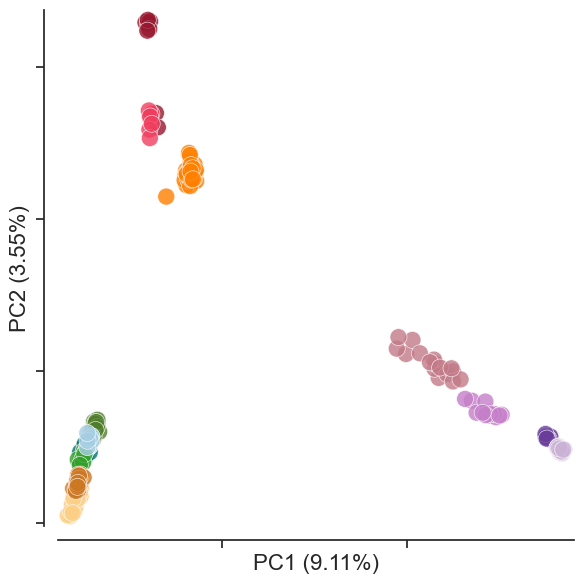

In [23]:
sns.set_style("white")  # Options: white, dark, whitegrid, darkgrid, ticks

plot_pcfig(model_sub_chr2, var_sub_chr2, pal=pop_code_cols, figname='pca_ab')

Now let's analyse the invasive range

In [24]:
mod_invasiverange, var_invasiverange = run_pca(chrom='CM023248',df_samples= df_samples, results_dir=outdir, analysis_name = '2597582', sample_query = 'country == "Sudan" | country == "Ethiopia" | country == "Djibouti" | country == "Yemen"', n_snps=100_000, min_minor_ac=2)

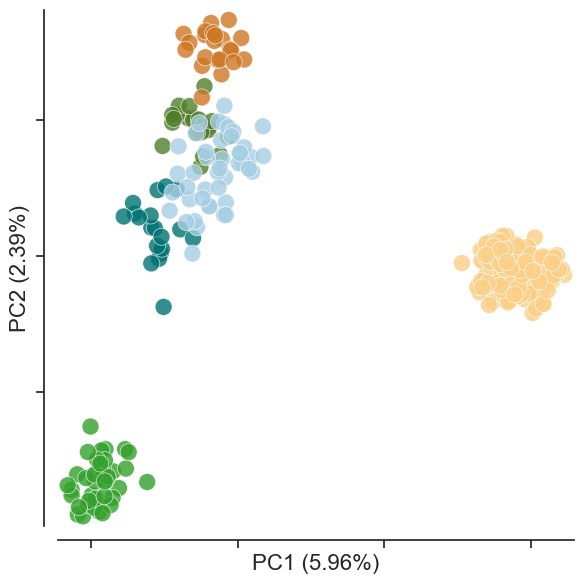

In [25]:
pinv = plot_pcfig(mod_invasiverange, var_invasiverange, pal=pop_code_cols, figname = 'pca_invasive')

Let's replot the chr3 and chrX PCAs for supp

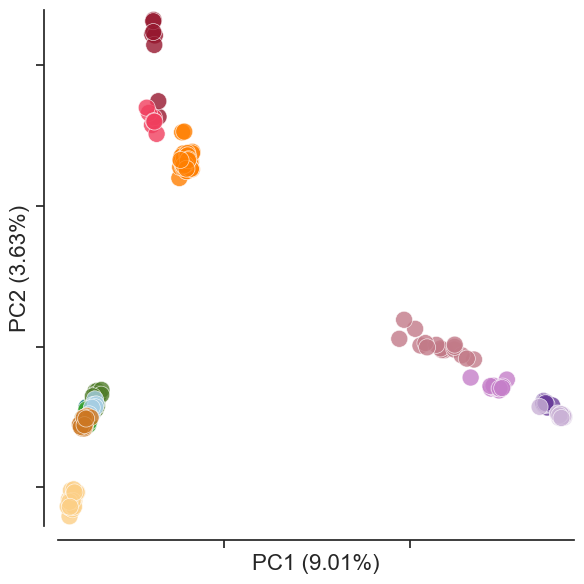

In [26]:
plot_pcfig(model_sub_chr3, var_sub_chr3, pal=pop_code_cols, figname='pca_chr3')

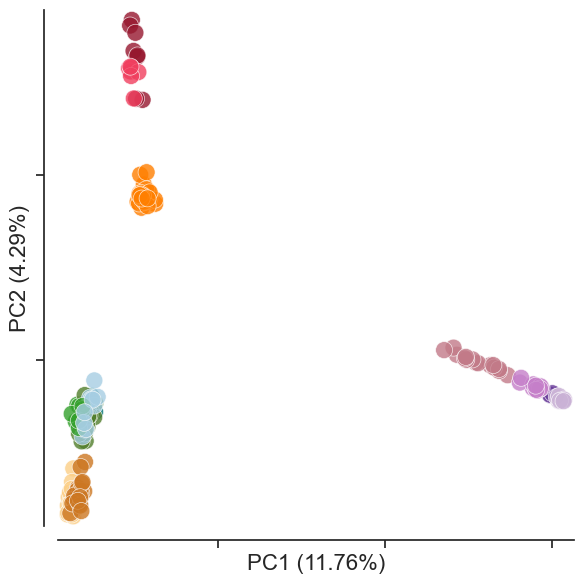

In [27]:
plot_pcfig(model_sub_chrX, var_sub_chrX, pal=pop_code_cols, figname='pca_chrX')

In [28]:
mod_invasiverange3, var_invasiverange3 = run_pca(chrom='CM023249',df_samples= df_samples, results_dir=outdir, analysis_name = '5757454', sample_query = 'country == "Sudan" | country == "Ethiopia" | country == "Djibouti" | country == "Yemen"', n_snps=100_000, min_minor_ac=2)
mod_invasiverangeX, var_invasiverangeX = run_pca(chrom='CM023250',df_samples= df_samples, results_dir=outdir, analysis_name = '7587575', sample_query = 'country == "Sudan" | country == "Ethiopia" | country == "Djibouti" | country == "Yemen"', n_snps=100_000, min_minor_ac=2)

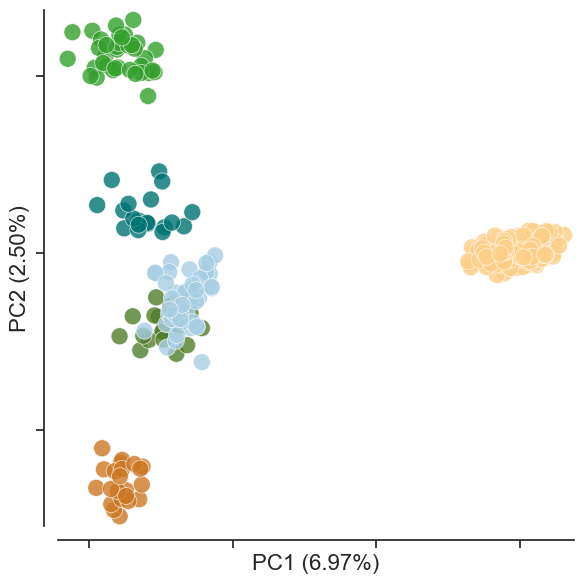

In [29]:
plot_pcfig(mod_invasiverange3, var_invasiverange3, pal=pop_code_cols, figname='inv_chr3')

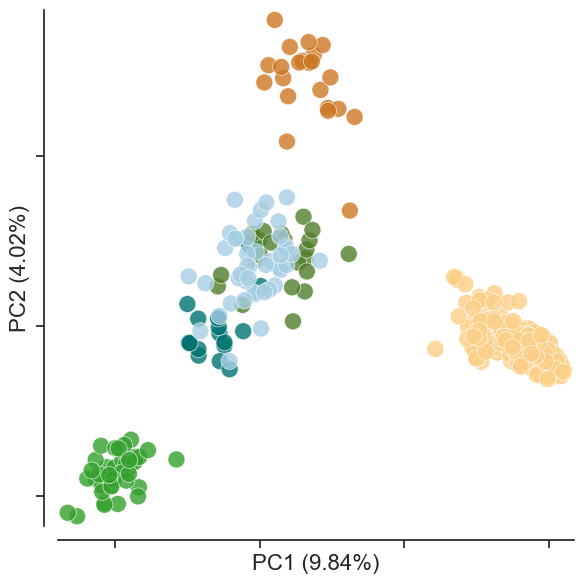

In [30]:
plot_pcfig(mod_invasiverangeX, var_invasiverangeX, pal=pop_code_cols, figname='inv_chrX')

In [31]:
plot_pcfig(mod_invasiverangeX, var_invasiverangeX, pal=analysis_popcols, figname='pca_inv_chrX')

NameError: name 'analysis_popcols' is not defined

In [32]:
mod_ethio, var_ethio = run_pca(chrom='CM023248',df_samples= df_samples, results_dir=outdir, analysis_name = '2948426', sample_query = 'country == "Ethiopia" | country == "Djibouti"', n_snps=100_000, min_minor_ac=2)

running analysis: f24f46a70fef2b755cf2b25366b7a442
setting up inputs
subsetting to segregating sites
selected 4154828 sites with a min mac > 2
subsetting to accessible sites only
locating segregating sites within desired frequency range
running PCA
saved results: f24f46a70fef2b755cf2b25366b7a442


In [38]:
plot_coords(mod_ethio, 'PC1', 'PC2', 
            colour = 'location', 
            palette = pop_code_cols,
            labs = {'PC1' : f'PC1 ({var_sub_chr3[0]*100:.2f}%)',
                    'PC2' : f'PC2 ({var_sub_chr3[1]*100:.2f}%)',
                    'country' : 'Country',
                    'analysis_pop' : 'Population'},)

In [39]:
plot_coords(mod_ethio, 'PC2', 'PC3', 
            colour = 'location', 
            palette = pop_code_cols,
            labs = {'PC2' : f'PC2 ({var_sub_chr3[1]*100:.2f}%)',
                    'PC3' : f'PC3 ({var_sub_chr3[2]*100:.2f}%)',
                    'country' : 'Country',
                    'analysis_pop' : 'Population'},)